In [1]:
# !pip install --user convertdate lunarcalendar holidays

# !pip install --user pystan==2.19.1.1 #--upgrade --force-reinstall  --no-cache

# !pip install --user prophet

# !pip install --user scikit-hts[prophet] #--upgrade --force-reinstall --no-cache

# !pip install --user plotly

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
from collections import defaultdict
from dateutil.relativedelta import relativedelta
import hts

TIME_COL = 'trx_date'
TARGET_COL = 'unique_tickets'
VALIDATION_DAYS = 31

## Подгружаем датасет

In [3]:
df = pd.read_parquet('./agg4')

if TIME_COL == 'TRX_DATE':
    df[TIME_COL] = pd.to_datetime(df[TIME_COL])
else:
    df[TIME_COL]=pd.to_datetime(df[['trx_year', 'trx_month']].rename(
        columns={'trx_year':'YEAR','trx_month':'MONTH'}).assign(DAY=1))

df.rename(columns={'SERVICE_APP': 'app', 'SALE_CHANNEL': 'channel', 'SERVICE_CLASS': 'cl'}, inplace=True)

groups = ['trx_date','app', 'channel', 'cl']

In [4]:
print(df.shape)
df.head()

(1399589, 21)


,app,channel,cl,OND,DEST_CITY_CODE,ORIG_CITY_CODE,ORIG_REGION_CODE,DEST_REGION_CODE,TRANSFER_PRODUCT,TARIF_GROUP,OPERATING_CARRIER_CODE,OPERATING_FLIGHT_NO,coupon_count,revenue,unique_tickets,sum_days_to_trip,sum_age_years,age_info_fill_count,trx_year,trx_month,trx_date
0,Android,WWW,C,AAQ-DME,MOW,AAQ,ЮРФ,MOW,PtP,BASIC,S7,1124.0,4.0,91953.0,4.0,0.0,0.000000,0.0,2019,1,2019-01-01
1,Android,WWW,C,AER-DME,MOW,AER,ЮРФ,MOW,PtP,FLEX,S7,1026.0,2.0,66230.0,2.0,0.0,0.000000,0.0,2019,1,2019-01-01
2,Android,WWW,C,AER-OVB,OVB,AER,ЮРФ,СРФ,PtP,BASIC,S7,3314.0,2.0,71308.0,2.0,26.0,120.860274,2.0,2019,1,2019-01-01
3,Android,WWW,C,AER-OVB,OVB,AER,ЮРФ,СРФ,PtP,BASIC,S7,3316.0,1.0,35654.0,1.0,10.0,51.989041,1.0,2019,1,2019-01-01
4,Android,WWW,C,BAX-DME,MOW,BAX,СРФ,MOW,PtP,BASIC,S7,218.0,1.0,43499.0,1.0,22.0,23.375342,1.0,2019,1,2019-01-01


# Описание набора функицй:
## Функция для создания групповой иерархии по набору категорий из датасета

Всех следующие функции на данный момент реализованы для иерархий глубиной до 3 уровней включительно

In [5]:
def make_grouped_hierarchy_by_cols(df, cols=[]):
    if len(cols) == 0:
        hierarchy = {'total': 'total_1'}
    
    if len(cols) == 1:
        lev_1 = [f'{cols[0]}={x}' for x in df[cols[0]].unique()]
        hierarchy = {'total' : lev_1}
    
    if len(cols) == 2:
        lev_1 = [f'{cols[0]}={x}' for x in df[cols[0]].unique()]
        lev_2 = [f'{cols[1]}={x}' for x in df[cols[1]].unique()]
        
        second_level=defaultdict(set)
        for cat_1, cat_2 in itertools.product(lev_1, lev_2):
            second_level[cat_1].add(f'{cat_1}_{cat_2}')
            
        for k, v in second_level.items():
            second_level[k] = list(v)
            
        hierarchy = {'total' : lev_1 + lev_2, **second_level}
    
    if len(cols) == 3:
        lev_1 = [f'{cols[0]}={x}' for x in df[cols[0]].unique()]
        lev_2 = [f'{cols[1]}={x}' for x in df[cols[1]].unique()]
        lev_3 = [f'{cols[2]}={x}' for x in df[cols[2]].unique()]
        
        second_level=defaultdict(set)
        third_level=defaultdict(set)
        for cat_1, cat_2, cat_3 in itertools.product(lev_1, lev_2, lev_3):
            second_level[cat_1].add(f'{cat_1}_{cat_2}')
            third_level[f'{cat_1}_{cat_2}'].add(f'{cat_1}_{cat_2}_{cat_3}')
            
        for k, v in second_level.items():
            second_level[k] = list(v)
            
        for k, v in third_level.items():
            third_level[k] = list(v)
            
        hierarchy = {'total' : lev_1 + lev_2 + lev_3, **second_level, **third_level}
        
    return hierarchy

### Вот например групповая иерархия, где на первом уровне классы, а на втором - их декомпозиция на приложения. На нулевом уровне всегда total

In [6]:
make_grouped_hierarchy_by_cols(df, ['cl', 'app'])

{'total': ['cl=C',
  'cl=Y',
  'app=Android',
  'app=Iphone',
  'app=Web-mobile',
  'app=С7Б аэропорт',
  'app=С7Б город',
  'app=С7С аэропорт',
  'app=С7С город'],
 'cl=C': ['cl=C_app=С7С аэропорт',
  'cl=C_app=Iphone',
  'cl=C_app=С7С город',
  'cl=C_app=Android',
  'cl=C_app=С7Б аэропорт',
  'cl=C_app=Web-mobile',
  'cl=C_app=С7Б город'],
 'cl=Y': ['cl=Y_app=Iphone',
  'cl=Y_app=Web-mobile',
  'cl=Y_app=С7Б аэропорт',
  'cl=Y_app=Android',
  'cl=Y_app=С7С аэропорт',
  'cl=Y_app=С7С город',
  'cl=Y_app=С7Б город']}

## Функция для получения статистик по выбранным категориям

In [7]:
def make_grouped_df(df, cols=[], hierarchy=None):
    if not hierarchy:
        hierarchy = make_grouped_hierarchy_by_cols(df, cols)
    
    new = df.groupby([TIME_COL] + cols).sum().reset_index().set_index(TIME_COL)[cols + [TARGET_COL]]
    new = pd.get_dummies(new, prefix_sep='=')
    
    if len(cols) == 0:
        new = new.rename(columns={TARGET_COL: 'total'})[['total']]
        
    if len(cols) == 1:
        new = new.apply(lambda x: x * x.unique_tickets, axis=1).drop(TARGET_COL, axis=1).reset_index().groupby(TIME_COL).sum()
        
    if len(cols) == 2:
        cols_to_drop = new.columns
        second_level_dict = {k: v for k, v in hierarchy.items() if k.count(cols[0]) == 1}
        second_level_names = [item for sublist in second_level_dict.values() for item in sublist]
        
        for name in second_level_names:
            cat_1, cat_2 = name.split('_')
            new[name] = new.unique_tickets * new[cat_1] * new[cat_2]
        new = new.drop(cols_to_drop, axis=1).reset_index().groupby(TIME_COL).sum()
        
    if len(cols) == 3:
        cols_to_drop = new.columns
        third_level_dict = {k: v for k, v in hierarchy.items() if k.count(cols[0]) == 1 and k.count(cols[1]) == 1}
        third_level_names = [item for sublist in third_level_dict.values() for item in sublist]
        
        for name in third_level_names:
            cat_1, cat_2, cat_3 = name.split('_')
            new[name] = new.unique_tickets * new[cat_1] * new[cat_2] * new[cat_3]
        new = new.drop(cols_to_drop, axis=1).reset_index().groupby(TIME_COL).sum()
    return new

In [8]:
make_grouped_df(df, ['cl', 'app']).head(10)

,cl=C_app=С7С аэропорт,cl=C_app=Iphone,cl=C_app=С7С город,cl=C_app=Android,cl=C_app=С7Б аэропорт,cl=C_app=Web-mobile,cl=C_app=С7Б город,cl=Y_app=Iphone,cl=Y_app=Web-mobile,cl=Y_app=С7Б аэропорт,cl=Y_app=Android,cl=Y_app=С7С аэропорт,cl=Y_app=С7С город,cl=Y_app=С7Б город
trx_date,,,,,,,,,,,,,,
2019-01-01,0.0,825.0,0.0,156.0,56.0,268.0,143.0,80090.0,81441.0,8686.0,47984.0,0.0,0.0,24759.0
2019-02-01,0.0,968.0,0.0,191.0,42.0,245.0,176.0,80220.0,76059.0,8312.0,46845.0,0.0,0.0,24701.0
2019-03-01,0.0,1161.0,0.0,161.0,26.0,360.0,199.0,106232.0,108929.0,9898.0,67417.0,0.0,0.0,31086.0
2019-04-01,27.0,1010.0,10.0,178.0,19.0,320.0,150.0,94595.0,100065.0,6720.0,58239.0,5213.0,1563.0,20263.0
2019-05-01,41.0,1025.0,32.0,166.0,7.0,435.0,80.0,88821.0,102027.0,2861.0,56069.0,6107.0,1609.0,4393.0
2019-06-01,39.0,1488.0,9.0,285.0,0.0,607.0,70.0,99796.0,115756.0,0.0,61572.0,6958.0,2396.0,2932.0
2019-07-01,66.0,1941.0,19.0,417.0,0.0,736.0,0.0,112754.0,116062.0,0.0,69187.0,6882.0,1796.0,17.0
2019-08-01,59.0,1892.0,23.0,419.0,0.0,673.0,0.0,109259.0,115328.0,0.0,65621.0,7001.0,1391.0,0.0
2019-09-01,80.0,1715.0,19.0,431.0,0.0,630.0,0.0,121806.0,114629.0,0.0,81654.0,6212.0,1094.0,0.0


## Функция для получения аггрегированного датасета и иерархии по выбранным категориям

In [9]:
def make_grouped_df_and_hierarchy_by_cols(df, cols=[]):
    hierarchy = make_grouped_hierarchy_by_cols(df, cols)
    
    if len(cols) == 0:
        new = pd.concat([
            make_grouped_df(df, hierarchy=hierarchy),
            make_grouped_df(df, hierarchy=hierarchy).rename(columns={'total': 'total_1'})
        ], axis=1)
        
    else:
        to_concat = [make_grouped_df(df, hierarchy=hierarchy)]
        for col in cols:
            to_concat.append(make_grouped_df(df, [col], hierarchy))
        if len(cols) > 1:
            for i in range(2, len(cols) + 1):
                to_concat.append(make_grouped_df(df, cols[:i], hierarchy))
                
        new = pd.concat(to_concat, axis=1)
        
    return new, hierarchy

### С помощью данной функции можем получить иерархию и датасет, с которыми уже работает сама библиотека

In [10]:
make_grouped_df_and_hierarchy_by_cols(df, ['cl', 'app'])[0].head(10)

,total,cl=C,cl=Y,app=Android,app=Iphone,app=Web-mobile,app=С7Б аэропорт,app=С7Б город,app=С7С аэропорт,app=С7С город,cl=C_app=С7С аэропорт,cl=C_app=Iphone,cl=C_app=С7С город,cl=C_app=Android,cl=C_app=С7Б аэропорт,cl=C_app=Web-mobile,cl=C_app=С7Б город,cl=Y_app=Iphone,cl=Y_app=Web-mobile,cl=Y_app=С7Б аэропорт,cl=Y_app=Android,cl=Y_app=С7С аэропорт,cl=Y_app=С7С город,cl=Y_app=С7Б город
trx_date,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,244408.0,1448.0,242960.0,48140.0,80915.0,81709.0,8742.0,24902.0,0.0,0.0,0.0,825.0,0.0,156.0,56.0,268.0,143.0,80090.0,81441.0,8686.0,47984.0,0.0,0.0,24759.0
2019-02-01,237759.0,1622.0,236137.0,47036.0,81188.0,76304.0,8354.0,24877.0,0.0,0.0,0.0,968.0,0.0,191.0,42.0,245.0,176.0,80220.0,76059.0,8312.0,46845.0,0.0,0.0,24701.0
2019-03-01,325469.0,1907.0,323562.0,67578.0,107393.0,109289.0,9924.0,31285.0,0.0,0.0,0.0,1161.0,0.0,161.0,26.0,360.0,199.0,106232.0,108929.0,9898.0,67417.0,0.0,0.0,31086.0
2019-04-01,288372.0,1714.0,286658.0,58417.0,95605.0,100385.0,6739.0,20413.0,5240.0,1573.0,27.0,1010.0,10.0,178.0,19.0,320.0,150.0,94595.0,100065.0,6720.0,58239.0,5213.0,1563.0,20263.0
2019-05-01,263673.0,1786.0,261887.0,56235.0,89846.0,102462.0,2868.0,4473.0,6148.0,1641.0,41.0,1025.0,32.0,166.0,7.0,435.0,80.0,88821.0,102027.0,2861.0,56069.0,6107.0,1609.0,4393.0
2019-06-01,291908.0,2498.0,289410.0,61857.0,101284.0,116363.0,0.0,3002.0,6997.0,2405.0,39.0,1488.0,9.0,285.0,0.0,607.0,70.0,99796.0,115756.0,0.0,61572.0,6958.0,2396.0,2932.0
2019-07-01,309877.0,3179.0,306698.0,69604.0,114695.0,116798.0,0.0,17.0,6948.0,1815.0,66.0,1941.0,19.0,417.0,0.0,736.0,0.0,112754.0,116062.0,0.0,69187.0,6882.0,1796.0,17.0
2019-08-01,301666.0,3066.0,298600.0,66040.0,111151.0,116001.0,0.0,0.0,7060.0,1414.0,59.0,1892.0,23.0,419.0,0.0,673.0,0.0,109259.0,115328.0,0.0,65621.0,7001.0,1391.0,0.0
2019-09-01,328270.0,2875.0,325395.0,82085.0,123521.0,115259.0,0.0,0.0,6292.0,1113.0,80.0,1715.0,19.0,431.0,0.0,630.0,0.0,121806.0,114629.0,0.0,81654.0,6212.0,1094.0,0.0


## Функция для обучения модели из библиотеки scikit-hts и получения предсказаний на указанное число дней
В данной реализации обучается на неполном датасете (присутствует откат на VALIDATION_DAYS), чтобы на последнем кусочке данных можно было валидироваться

In [11]:
def hts_fit_predict(grouped_df, hierarchy, model='auto_arima', revision_method='OLS', validation_days=VALIDATION_DAYS):
    reg = hts.HTSRegressor(
        model=model, 
        revision_method=revision_method, # "OLS", "WLSS", "WLSV", "FP", "PHA", "AHP", "BU", "NONE"
        #weekly_seasonality = True,
        #daily_seasonality = True,
        #yearly_seasonality = True,
        n_jobs=0,
    )
    reg = reg.fit(df=grouped_df.loc[:grouped_df.index[-1] - pd.Timedelta(days=validation_days), :], nodes=hierarchy)
    preds = reg.predict(steps_ahead=validation_days)
    return preds

## Функция для сравнения графиков предсказаний и реальных данных для всех вершин иерархии

In [12]:
def plot_results(grouped_df, preds, hierarchy, validation_days=VALIDATION_DAYS):
    PLOT = ['total'] + [item for sublist in hierarchy.values() for item in sublist]

    fig, axs = plt.subplots(len(PLOT), figsize=(20, 30), sharex=True)


    for i, group in enumerate(PLOT):
        axs[i].plot(grouped_df[group], 
                lw=1.1, 
                color='#2ecc71', 
                alpha=0.8, 
                label='Truth')
        axs[i].plot(preds.loc[[x for x in preds.index if x.day == 1], :][group], 
                lw=1.1,
                color='#e74c3c', 
                alpha=0.8, 
                label='Prediction')
        axs[i].axvline(x=grouped_df.index[-1] - pd.Timedelta(days=validation_days)) #pd.to_datetime('2021-08-01'))
        axs[i].legend()
        axs[i].set_title(f'{group}')
    plt.show()

## Теперь можем перейти к обучению моделей

### Начнем с простой одноуровневой иерархии с разветвлением на 2 класса и посмотрим на результат предсказания

In [13]:
grouped_df, hierarchy = make_grouped_df_and_hierarchy_by_cols(df, ['cl'])

In [14]:
grouped_df.head(10)

,total,cl=C,cl=Y
trx_date,,,
2019-01-01,244408.0,1448.0,242960.0
2019-02-01,237759.0,1622.0,236137.0
2019-03-01,325469.0,1907.0,323562.0
2019-04-01,288372.0,1714.0,286658.0
2019-05-01,263673.0,1786.0,261887.0
2019-06-01,291908.0,2498.0,289410.0
2019-07-01,309877.0,3179.0,306698.0
2019-08-01,301666.0,3066.0,298600.0
2019-09-01,328270.0,2875.0,325395.0


In [15]:
tree = hts.hierarchy.HierarchyTree.from_nodes(hierarchy, grouped_df)
sum_mat, sum_mat_labels = hts.functions.to_sum_mat(tree)

In [16]:
print('total')
print(tree.children)

total
[- cl=C
, - cl=Y
]


In [17]:
sum_mat

array([[1., 1.],
       [1., 0.],
       [0., 1.]])

In [18]:
preds = hts_fit_predict(grouped_df, hierarchy, model='auto_arima', revision_method='OLS')

Fitting models:   0%|          | 0/3 [00:00<?, ?it/s]/home/jovyan/.local/lib/python3.9/site-packages/pmdarima/arima/arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "
/home/jovyan/.local/lib/python3.9/site-packages/pmdarima/arima/arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "
/home/jovyan/.local/lib/python3.9/site-packages/pmdarima/arima/arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "
Fitting models: 100%|██████████| 3/3 [00:00<00:00, 266.08it/s]


In [19]:
preds.tail()

,total,cl=C,cl=Y
2021-07-28,546903.74994,4214.499881,542689.25006
2021-07-29,546903.74994,4214.499881,542689.25006
2021-07-30,546903.74994,4214.499881,542689.25006
2021-07-31,546903.74994,4214.499881,542689.25006
2021-08-01,546903.74994,4214.499881,542689.25006


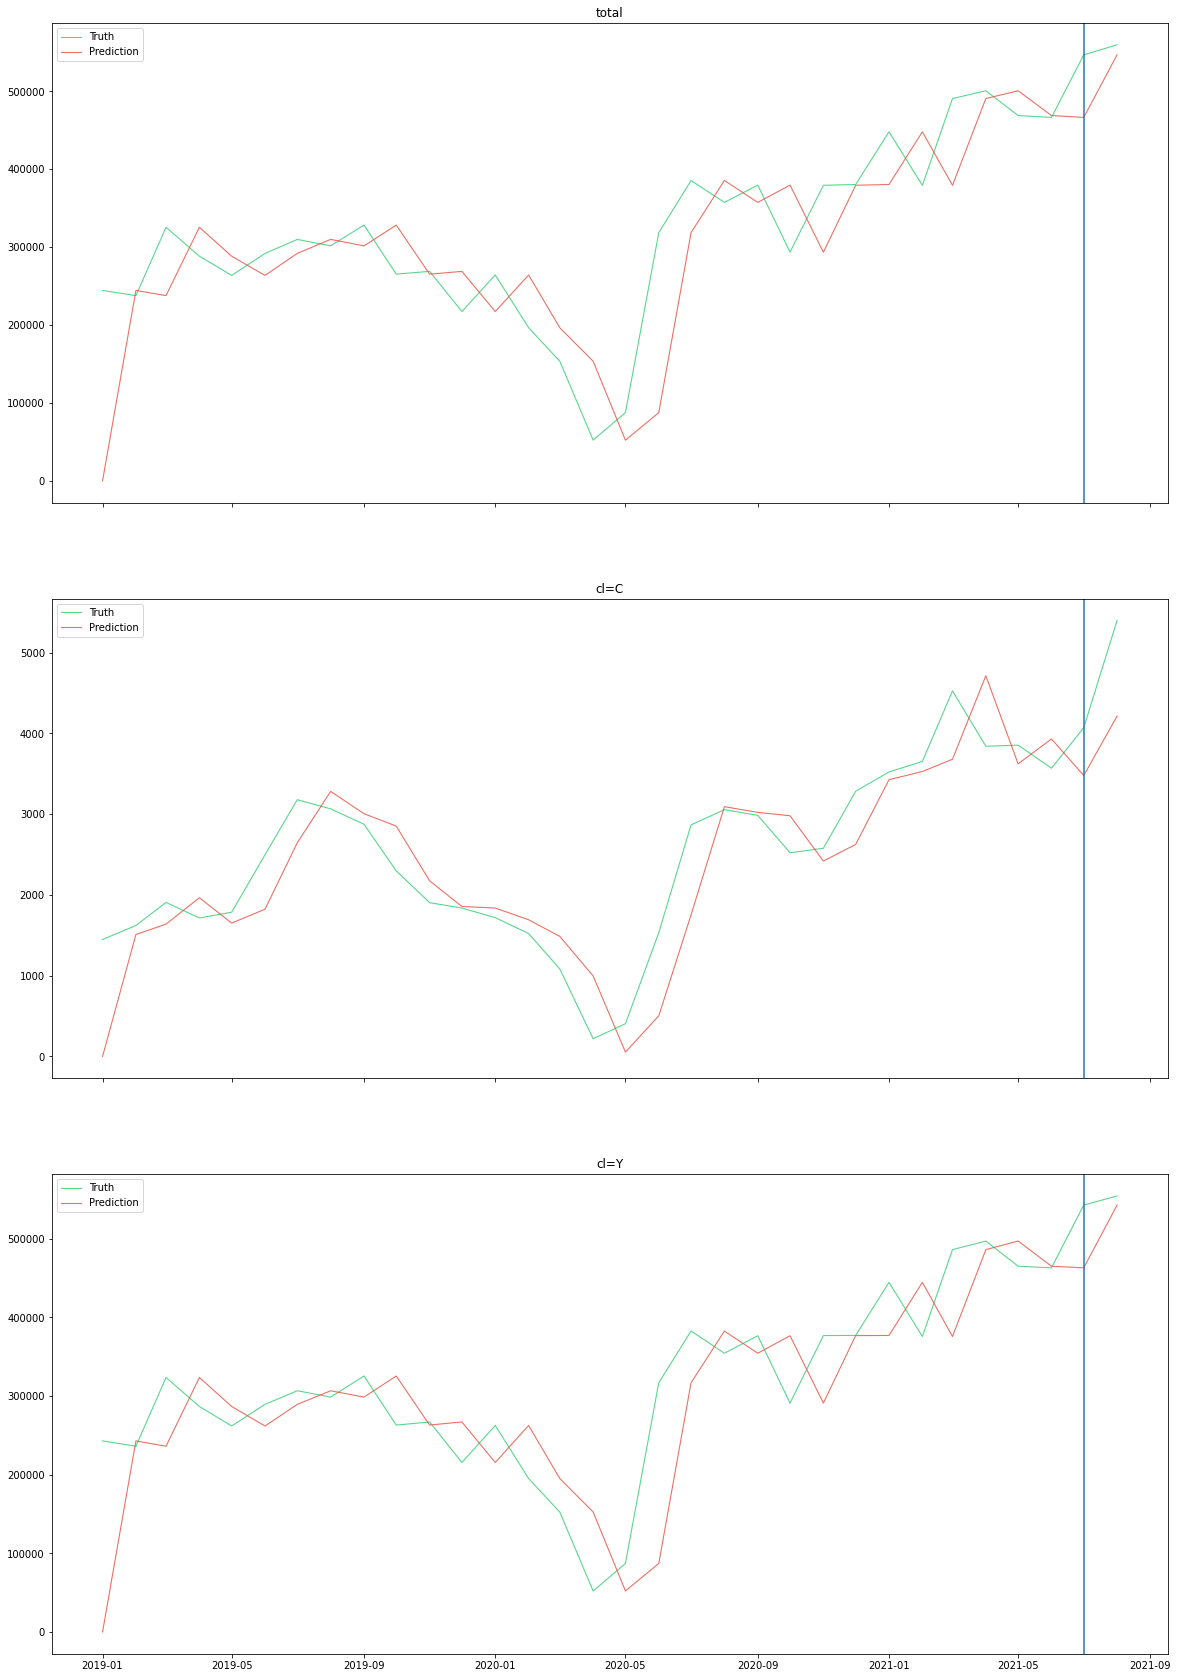

In [20]:
plot_results(grouped_df, preds, hierarchy)

### Видим, что auto_arima предсказывает просто предыдущее значение (график получился просто смещением на месяц вправо)
### Попробуем сделать то же самое, но для категории с большим количеством уникальных значений и модели prophet

In [13]:
grouped_df, hierarchy = make_grouped_df_and_hierarchy_by_cols(df, ['app'])

In [14]:
preds = hts_fit_predict(grouped_df, hierarchy, model='prophet', revision_method='OLS')

Fitting models:   0%|          | 0/8 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
Fitting models:  12%|█▎        | 1/8 [00:01<00:07,  1.07s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
Fitting models:  25%|██▌       | 2/8 [00:01<00:03,  1.56it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of 

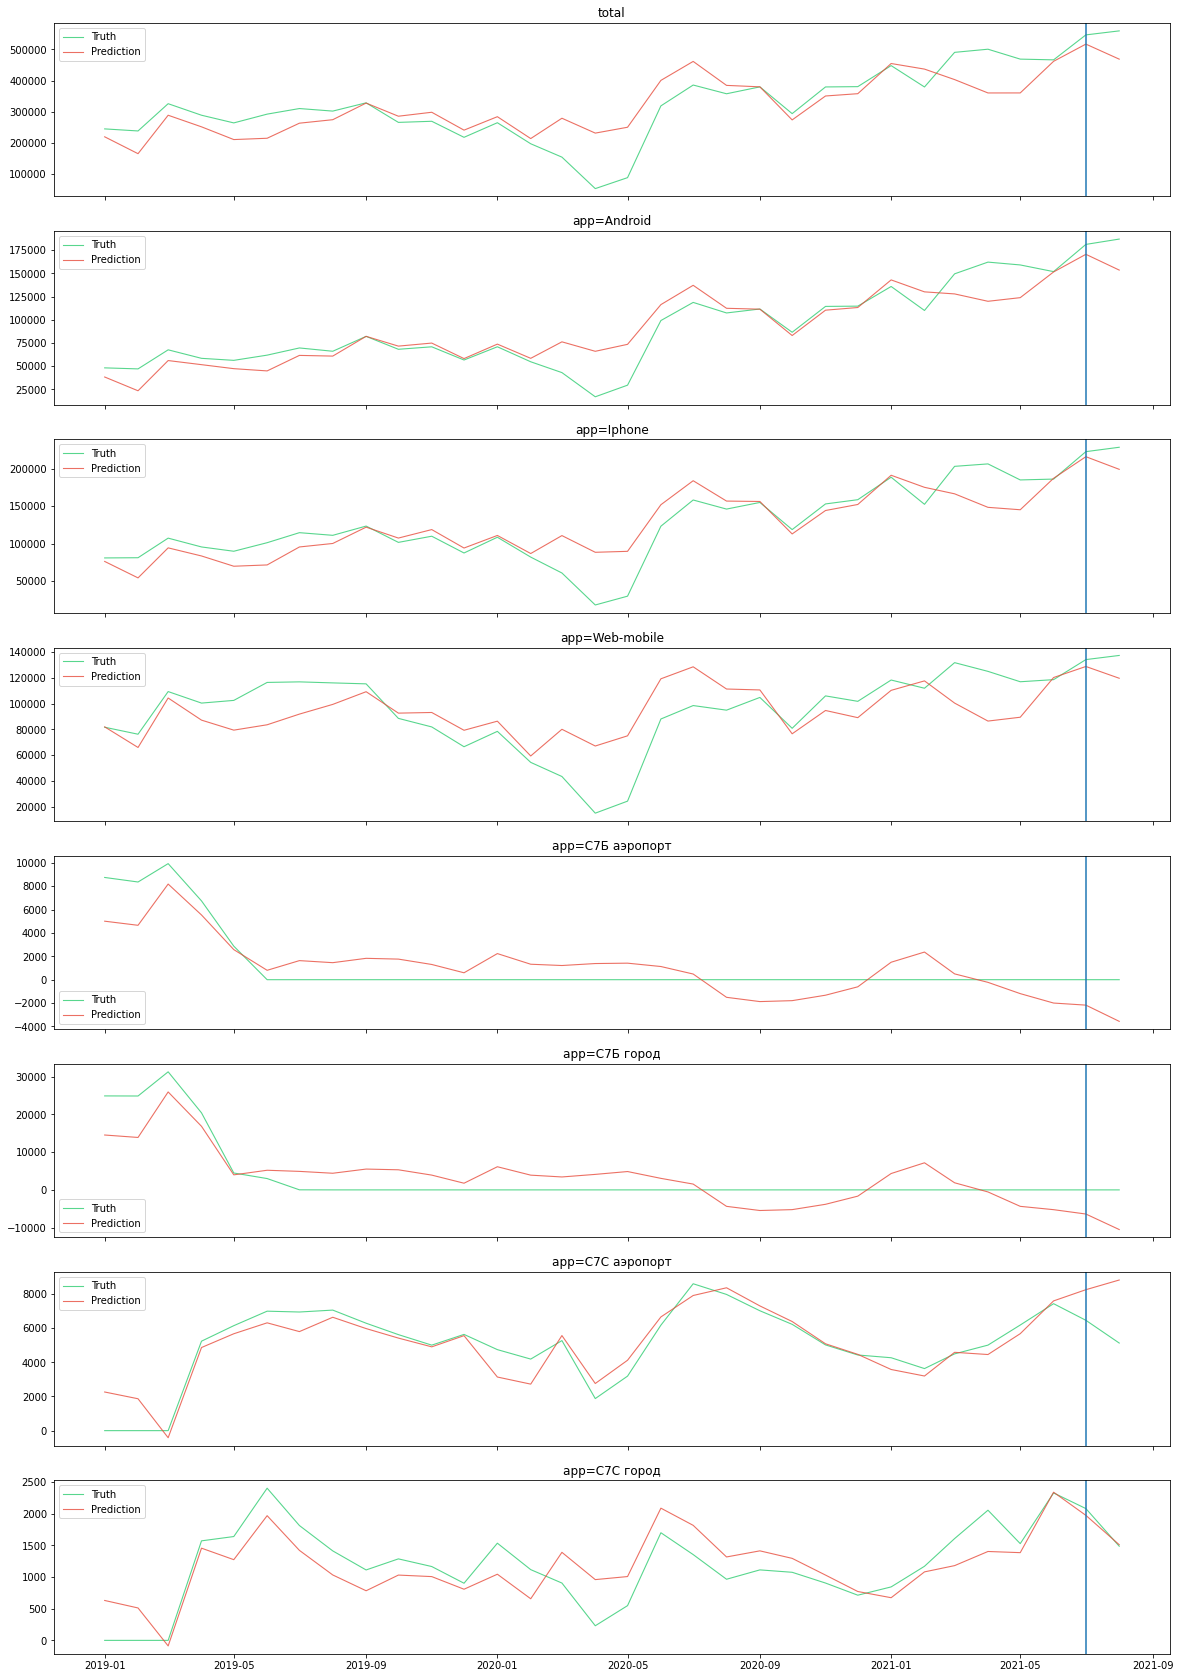

In [15]:
plot_results(grouped_df, preds, hierarchy)

### Хоть модель и старалась угадать тренд на трейне, на тестовом месяце получились не очень хорошие предсказания. Можем сделать вывод, что для временных рядов мало точек для обучения, когда используются данные по месяцам всего за 2 года

## Попробуем обучиться на двухуровевой иерархии

In [26]:
grouped_df, hierarchy = make_grouped_df_and_hierarchy_by_cols(df, ['cl', 'app'])

In [27]:
preds = hts_fit_predict(grouped_df, hierarchy, model='prophet', revision_method='OLS')

Fitting models:   0%|          | 0/24 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
Fitting models:   4%|▍         | 1/24 [00:00<00:06,  3.33it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
Fitting models:   8%|▊         | 2/24 [00:00<00:07,  3.06it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number 

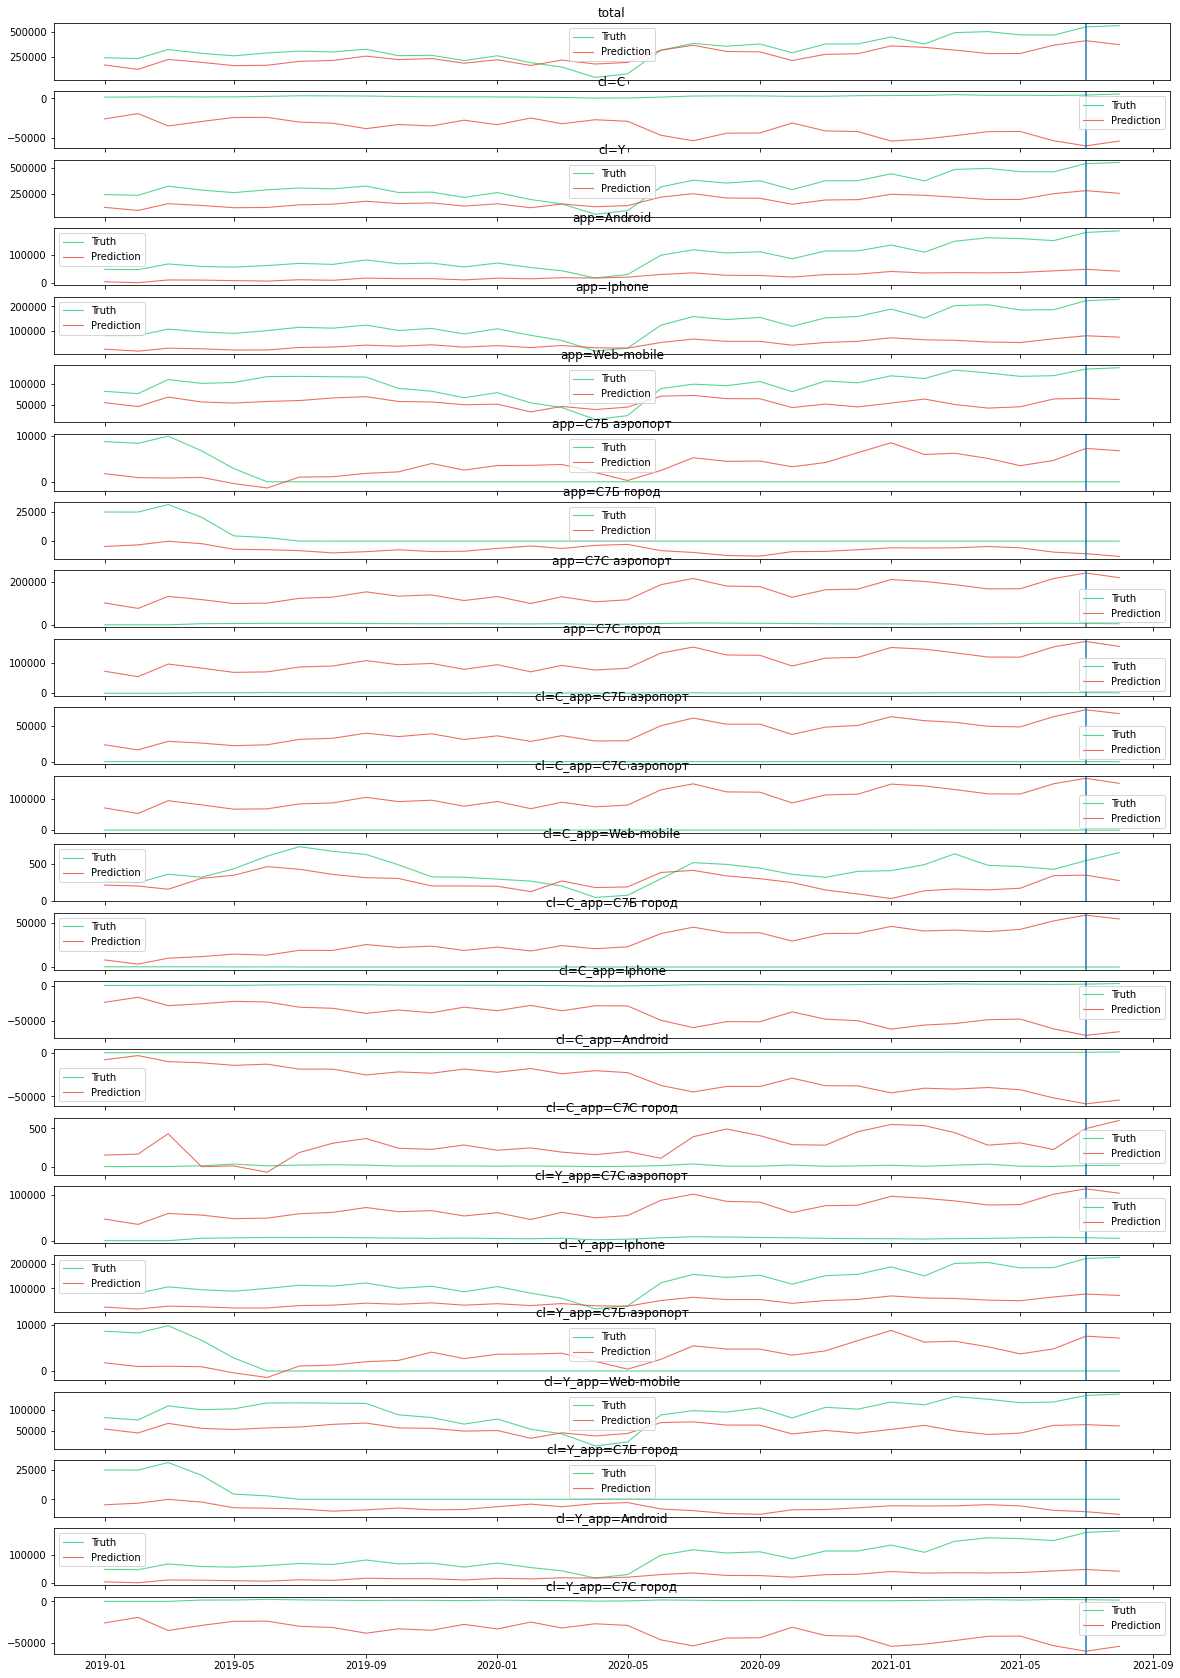

In [28]:
plot_results(grouped_df, preds, hierarchy)

## Видим, что модель очень плохо справляется даже с улавливанием тренда. Можно предположить, что с такой глубокой иерархией в датасете слишком много нулевых значений, что трудно предсказывать временным рядом, так как нули не дают никакой сезонной информации

## Построим систему проверки качества: будем обучаться на кусочке данных и сравнивать предсказание следующего дня с реальным значением

In [21]:
CHECK_POINTS = pd.to_datetime(['2019-12-01', '2020-03-01', '2020-07-01', 
                               '2020-12-01', '2021-03-01', '2021-06-01'])

def cross_val(real_df, hierarhy, method=None):
    diff_dfs = []
    
    for point in CHECK_POINTS:
        grouped_df = real_df.loc[:point, :]
        
        reg = hts.HTSRegressor(
            model='prophet',
            revision_method='OLS', # "OLS", "WLSS", "WLSV", "FP", "PHA", "AHP", "BU", "NONE"
            n_jobs=0
        )
        reg = reg.fit(df=grouped_df, nodes=hierarchy)
        preds = reg.predict(steps_ahead=VALIDATION_DAYS)

        diff_dfs.append(pd.concat([real_df.loc[[point + relativedelta(months=1)], :],
                        preds.loc[[point + relativedelta(months=1)], :] \
                                  .rename(columns={col : f'preds_{col}' for col in preds.columns})], axis=1))
    
    res = diff_dfs[0]
    for df in diff_dfs[1:]:
        res = pd.concat([res, df])
    
    res['percentage_diff_total'] = abs(res.total - res.preds_total) / res.total
    return res

Тут посчитано для случая одноуровневой иерархии

In [22]:
diff_df = cross_val(grouped_df, hierarchy)

Fitting models:   0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
Fitting models:  33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbpro

In [23]:
diff_df.round(2)

,total,cl=C,cl=Y,preds_total,preds_cl=C,preds_cl=Y,percentage_diff_total
2020-01-01,264254.0,1719.0,262535.0,275914.52,2622.53,273291.99,0.04
2020-04-01,52309.0,219.0,52090.0,221056.90,1908.60,219148.30,3.23
2020-08-01,357416.0,3056.0,354360.0,208515.90,1470.60,207045.30,0.42
2021-01-01,448036.0,3523.0,444513.0,303134.92,2447.58,300687.34,0.32
2021-04-01,500762.0,3841.0,496921.0,222887.53,1588.39,221299.14,0.55
2021-07-01,546832.0,4071.0,542761.0,496555.53,4322.68,492232.85,0.09


# Prophet без иерархии

In [32]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import os

In [33]:
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [34]:
hierarchy

{'total': ['app=Android',
  'app=Iphone',
  'app=Web-mobile',
  'app=С7Б аэропорт',
  'app=С7Б город',
  'app=С7С аэропорт',
  'app=С7С город']}

In [42]:
metrics = []

for TARGET in grouped_df.columns:
    params = {
        'growth': 'linear',
        'weekly_seasonality': True,
        'daily_seasonality': True,
        'yearly_seasonality': True,
        'holidays_prior_scale': 0.25,
    }

    m = Prophet(**params)
    m.add_country_holidays(country_name='RU')
    with suppress_stdout_stderr():
        m.fit(grouped_df.loc[:grouped_df.index[-1] - pd.Timedelta(days=VALIDATION_DAYS), :][[TARGET]].reset_index().rename(columns={TARGET:'y', TIME_COL:'ds'}))

    future = m.make_future_dataframe(periods=VALIDATION_DAYS, freq='D')
    future = future.merge(grouped_df[[TARGET]], left_on='ds', right_on=TIME_COL, how='inner')

    forecast = m.predict(future)

    prophet_preds = grouped_df.loc[grouped_df.index[-1] - pd.Timedelta(days=VALIDATION_DAYS):, :].merge(forecast, left_index=True, right_on='ds', how='inner')
    
    hts_preds = grouped_df.loc[grouped_df.index[-1] - pd.Timedelta(days=VALIDATION_DAYS):, :].merge(preds, left_index=True, right_index=True, how='inner')
    print(f'-------{TARGET}:')
    print(f'MAE common prophet = {mean_absolute_error(prophet_preds[TARGET], prophet_preds.yhat)}')
    print(f'MAE hts prophet = {mean_absolute_error(hts_preds[f"{TARGET}_x"], hts_preds[f"{TARGET}_y"])}')
    
    metrics.append([mean_absolute_error(prophet_preds[TARGET], prophet_preds.yhat), 
    mean_absolute_error(hts_preds[f'{TARGET}_x'], hts_preds[f'{TARGET}_y'])])

INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 23.


-------total:
MAE common prophet = 287287.22279075714
MAE hts prophet = 60297.45557431065


INFO:prophet:n_changepoints greater than number of observations. Using 23.


-------app=Android:
MAE common prophet = 83668.42345444698
MAE hts prophet = 22050.403269609305


INFO:prophet:n_changepoints greater than number of observations. Using 23.


-------app=Iphone:
MAE common prophet = 109837.62345418625
MAE hts prophet = 18141.709402111825


INFO:prophet:n_changepoints greater than number of observations. Using 23.


-------app=Web-mobile:
MAE common prophet = 71076.60175111046
MAE hts prophet = 11486.066687784558


INFO:prophet:n_changepoints greater than number of observations. Using 23.


-------app=С7Б аэропорт:
MAE common prophet = 6288.646429865959
MAE hts prophet = 2868.3601877759193


INFO:prophet:n_changepoints greater than number of observations. Using 23.


-------app=С7Б город:
MAE common prophet = 18613.08031081494
MAE hts prophet = 8451.821686094438


INFO:prophet:n_changepoints greater than number of observations. Using 23.


-------app=С7С аэропорт:
MAE common prophet = 2274.1790077998785
MAE hts prophet = 2742.6255131221988
-------app=С7С город:
MAE common prophet = 670.9921431312935
MAE hts prophet = 65.46595799146598


### Заметим, что показатели очень близки, но в целом профет для каждого ряда по-отдельности работает стабильнее